# Scheduling

The objective of the scheduler is to assign jobs to resources. The scheduler policy determines the rules that dictate how to conduct this mapping under various objectives: makespan, slowdown, energy, waiting time, and many others. Batsim allow us to evaluate the performance of different schedulers under distinct scenarios.

The objective of this tutorial is to demonstrate how scheduling policies can be evaluated with batsim-py. First, we define the simulation inputs (platform and workload). Then, we implement the scheduling policy. Lastly, we run the simulation to collect statistics about the performance of each scheduling policy implemented.

## Simulation Inputs

To evaluate the scheduler performance, we must define a platform and one or more workloads. The platform will describe how the computing resources are distributed and their performance (measured in flop/s), while the workload will simulate user behavior and describe the jobs to be submitted to the system.

### Platform

For this tutorial, we will define the platform as a cluster of 2 computing 
resources (hosts) without networking and storage resources. Moreover, we define 
just 1 power state as we are not interested in the energy consumption of the hosts. 
Check the [Shutdown tutorial](shutdown.rst) if you want to know how to use the 
energy model.

<div class="alert alert-info">

**Note**

To fully understand the platform description, you are encouraged to read the [Simgrid documentation](https://simgrid.org/doc/latest/XML_Reference.html#platform-reference).

</div>

To summarize the platform:

- We define a **"master_host"** (check the ``id`` attribute) to be used by our scheduler (by Batsim). This host won't be accounted in the simulation results (only Batsim can use this host).
- For each host, we define just one power state. This means we're unable to shutdown or boot the hosts. 
- The power state (0) defines:

    - The host can compute 1000010.0 flop/s.
    - The host consumes 190.1 Watts when it's computing a job and 95.0 Watts when it's idle.

<div class="alert alert-warning">

**Warning**
    
When you define a time $t$ to proceed the simulation in Batsim-py, only the events that happened before $t$ will be dispatched $< t$. This is the reason we defined the host speed to be $1000010.0$ flop/s instead of $1000000$ flop/s. Otherwise, a job that computes $1$ Mf would not dispatch a completed event if we proceed the time in 1 second, it would only dispatch if we proceed the time in 1.1 seconds.

</div>

### Workload

After describing the platform, we must specify the workload. Let's define a simple workload of 4 jobs and 2 simples profiles with cpu only.

To summarize the workload:

- We define 4 jobs to be submitted in different simulation times (1, 5 and 10 seconds).
- We define 2 profiles to specify how many flops/s (``cpu``) the job will compute on each requested hosts (80 Mf and 120 Mf).

<div class="alert alert-info">

**Note**
    
To fully understand the workload format, you're encouraged to read the great [Batsim documentation](https://batsim.readthedocs.io/en/latest/input-workload.html)

</div>

## Schedulers

### First Come First Served (FCFS) 

The FCFS policy schedule jobs by the order of their arrival. Thus, we only need 
to know the jobs submission time (to give execution priorities) and the number 
of resources available (assuming that a host can compute a single job per 
time):

In [1]:
from batsim_py.simulator import SimulatorHandler

class FCFSScheduler:
    def __init__(self, simulator: SimulatorHandler) -> None:
        self.simulator = simulator

    def __str__(self) -> str:
        return "FCFS"
        
    def schedule(self) -> None:
        assert self.simulator.is_running

        for job in self.simulator.queue:
            available = self.simulator.platform.get_not_allocated_hosts()  # Hosts

            if job.res <= len(available):
                # Schedule if the job can start now.
                allocation = [h.id for h in available[:job.res]]
                self.simulator.allocate(job.id, allocation)
            else:
                # Otherwise, wait for resources.
                break

We start defining a simple class and we do not follow an event-based design. Thus, the scheduler will only take decisions when it’s directly called.

The implementation is very simple and the policy rules are implemented in the schedule method. 

For each job in the queue, we check if there are resources available. Available resources are those that are not allocated for any job. If there are available resources for the first job in the queue, we allocate resources to it. Otherwise, we stop scheduling and wait until the required number of resources are released.

<div class="alert alert-info">

**Note**
    
If you want an event-based design, you can use the dispatching mechanism to subscribe to job events. Refer to the [Dispatcher docs](../api_doc/dispatcher.rst) for further information.

</div>

### EASY Backfilling (EASY) 

The EASY policy extends the FCFS to increase its efficiency. A disadvantage of the FCFS is that some resources may remain idle even though there are jobs in the queue that could use it.

To solve this inefficiency and prevent job starvation, the EASY policy implements a backfilling mechanism that allows short jobs to skip ahead provided they do not delay the job at the head of the queue (called priority job).

Therefore, to implement the EASY scheduler we just need to extend the FCFS to include this mechanism.

In [2]:
class EASYScheduler(FCFSScheduler):
    def __str__(self) -> str:
        return "EASY"

    def schedule(self) -> None:
        # Schedule with FCFS
        super().schedule()
        
        # Apply the backfilling mechanism
        if len(self.simulator.queue) >= 2: 
            self.backfill()

    def backfill(self) -> None:
        assert len(self.simulator.queue) >= 2

        # The priority job is the first of the queue.
        p_job = self.simulator.queue[0]

        # The remaining jobs can be scheduled if they do not delay the p_job.
        backfilling_queue = self.simulator.queue[1:]

        # Get the next expected releases
        next_releases = sorted(self.simulator.agenda, key=lambda a: a.release_time)

        # Get the last required host for p_job.
        last_host = next_releases[p_job.res - 1]

        # The last host release time will be the p_job expected start time.
        p_start_t = last_host.release_time

        # Find candidates and reserve resources for p_job.
        candidates = [r.host_id for r in next_releases if r.release_time <= p_start_t]
        
        # Try to maximize the number of hosts for the remaining queue.
        reservation = candidates[-p_job.res:]

        # Let's try to start some jobs earlier.
        for job in backfilling_queue:
            available = self.simulator.platform.get_not_allocated_hosts()  # Hosts
            not_reserved = [h for h in available if h.id not in reservation]

            if job.res <= len(not_reserved):
                # Schedule job on not reserved hosts.                
                allocation = [h.id for h in not_reserved[:job.res]]
                self.simulator.allocate(job.id, allocation)
            elif job.walltime and job.walltime <= p_start_t and job.res <= len(available):
                # Schedule job on reserved hosts without delaying p_job.                
                allocation = [h.id for h in available[:job.res]]
                self.simulator.allocate(job.id, allocation)

We begin the EASY implementation by inheriting the ``FCFSScheduler`` class. After the FCFS finishes scheduling jobs, we try to fill the gaps with the remaining queue. This is exactly what we do in the ``schedule`` method. We start the backfilling mechanism only if there are more than 2 jobs in the queue. Otherwise, it'd not make sense.

The backfilling mechanism is simple. First, we estimate when the required number of resources to start the priority job will be available. This estimation is based on the ``walltime`` property that each job provides in the workload and is given by the [agenda](../api_doc/simulator.rst#batsim_py.simulator.SimulatorHandler.agenda) property of the simulator. Once we know the expected start time of the priority job (``p_start_t``) we can find some candidates (hosts) to be reserved. 

For candidates, we select all hosts that will be available before ``p_start_t``. Then, we try to reserve the candidates that are close to ``p_start_t`` in order to maximize the hosts available for the backfilling queue. After that, we can start to fill the gaps with the jobs in the backfilling queue. Only jobs that can start on not reserved hosts or do not delay the execution of the priority job (``walltime`` $<=$ ``p_start_t``) will be scheduled. 

<div class="alert alert-info">

**Note**
    
If the job ``walltime`` is unset, the simulator cannot estimate the expected release time. In this case, the agenda will return [numpy.inf](https://numpy.org/devdocs/reference/constants.html#numpy.Inf) and the job cannot be anticipated by the backfilling mechanism.

</div>

## Running Simulation

After defining the simulation inputs and the schedulers we want to evaluate, it's time to run the simulation and collect some results.
  
The simulation procedure involves four steps:

In [3]:
import batsim_py

def run_simulation(scheduler):
    simulator = batsim_py.SimulatorHandler()
    scheduler = scheduler(simulator)

    # 1) Instantiate monitors to collect simulation statistics
    jobs_mon = batsim_py.monitors.JobMonitor(simulator)
    sim_mon = batsim_py.monitors.SimulationMonitor(simulator)

    # 2) Start simulation
    simulator.start(platform="platforms/hosts_2.xml",
                    workload="workloads/comp_4.json",
                    verbosity="information")

    # 3) Schedule all jobs
    while simulator.is_running:
        scheduler.schedule()
        simulator.proceed_time()  # proceed directly to the next event.
    simulator.close()

    # 4) Return/Dump statistics
    return jobs_mon, sim_mon

jobs_f, sim_f = run_simulation(FCFSScheduler)
jobs_e, sim_e = run_simulation(EASYScheduler)

We begin the simulation process by instantiating the simulator handler. This handler is passed as an argument when we instantiate monitors to collect statistics (check [Monitors docs](../api_doc/monitors.rst) for other options). 

After we define the monitors (**#1**) we can start the simulation by providing the inputs (**#2**). The simulation begins and while it's running we start the scheduling procedure. After the scheduler is done, we proceed the simulation time to the next event. This procedure is repeated until all jobs complete (**#3**). Lastly, we return the monitors in order to analyze it (**#4**). The monitors can also be used to dump the results into an external file.

<div class="alert alert-info">

**Note**
    
The [proceed_time](../api_doc/simulator.rst#batsim_py.simulator.SimulatorHandler.proceed_time) method of the simulator can also be used to proceed the simulation into a specific time. If no value is provided, the simulation will proceed the time directly to the next dispatched event.

</div>

## Analyzing Results

The last step in our scheduling evaluation is to analyze the results. The default monitors provide the most commonly used statistics, but you are free to extend it to cover specific scenarios.

First, we analyze the performance of each scheduler policy:

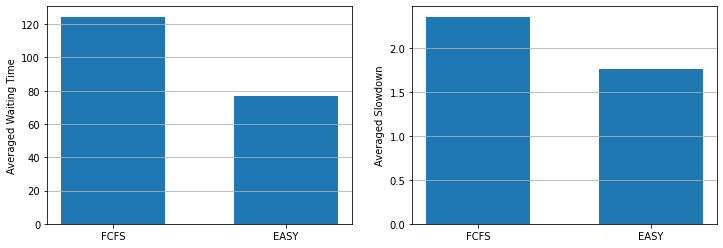

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Read results
fcfs, easy = sim_f.to_dataframe(), sim_e.to_dataframe()
fcfs['name'], easy['name'] = "FCFS", "EASY"
benchmark = pd.concat([fcfs, easy], ignore_index=True)

# Waiting time
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.bar('name', 'mean_waiting_time', data=benchmark, width=0.6)
plt.grid(axis='y')
plt.ylabel("Averaged Waiting Time")

# Slowdown
plt.subplot(1, 2, 2)
plt.bar('name', 'mean_slowdown', data=benchmark, width=0.6)
plt.grid(axis='y')
plt.ylabel("Averaged Slowdown")

# Show
plt.show()

Considering the averaged waiting time and slowdown, the EASY scheduler achieved the best performance. By implementing the EASY backfilling mechanism we were able to considerably minimize (on average) both the waiting time and slowdown of the jobs. 

To better understand where these gains come from, we can use the [evalys package](https://pypi.org/project/evalys/) to plot a Gantt chart:

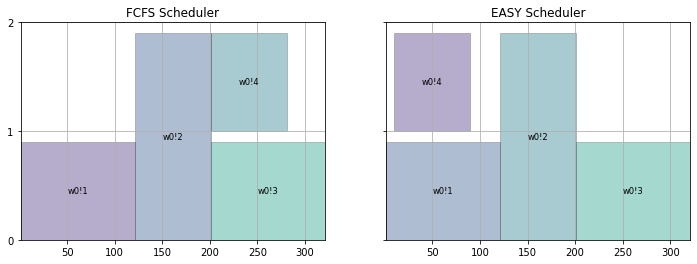

In [5]:
from evalys.jobset import JobSet
from evalys.visu.legacy import plot_gantt
    
# Convert monitors to dataframes
fcfs, easy = jobs_f.to_dataframe(), jobs_e.to_dataframe()

# Load dataframes into JobSet objects.
fcfs, easy = JobSet(fcfs), JobSet(easy)

# Plot gantts
_, ax_list = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
plot_gantt(fcfs, ax=ax_list[0], title="FCFS Scheduler")
plot_gantt(easy, ax=ax_list[1], title="EASY Scheduler")

# Show
plt.ylim(ymin=0, ymax=2)
plt.yticks([0, 1, 2]) # We have two hosts only.
plt.show()

Looking at the Gantt chart, we can observe the backfilling mechanism in action. The job ``w0!4`` was able to start before job ``w0!2`` without delaying it. Consequently, we achieved better waiting time and slowdown averages.

## Next Steps

This tutorial is a very simple example of how to evaluate two scheduling policies. Neither the platform nor the workload was realistic. Moreover, we didn't consider the energy model. So, as the next steps, you can extend this tutorial with other policies, workloads, and platforms.